# Проект "Предсказание температуры стали"

### Описание задачи

Наш заказчик – металлургический комбинат ООО "Так закаляем сталь" – решил уменьшить потребление электроэнергии на этапе обработки стали, чтобы оптимизировать производственные расходы. Нам предстоит построить модель, которая предскажет температуру стали

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют – изменяют её состав – подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»)

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»)

### Описание данных

Данные находятся в файлах, полученных из разных источников:

- `data_arc.csv` – данные об электродах
- `data_bulk.csv` – данные о подаче сыпучих материалов (объём)
- `data_bulk_time.csv` – данные о подаче сыпучих материалов (время)
- `data_gas.csv` – данные о продувке сплава газом
- `data_temp.csv` – результаты измерения температуры
- `data_wire.csv` – данные о проволочных материалах (объём)
- `data_wire_time.csv` — данные о проволочных материалах (время)

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки

Файлы находятся в тренажёре, в папке `/datasets/final_steel/`

Также их можно скачать по ссылке: [final_steel.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/f3fbea3a-263d-4e1c-babd-0bf07920c911/final_steel.zip)

### Дополнительно

- Для воспроизводимости результатов исследования необходима фиксация сидов: *RANDOM_STATE = 270323* (заказчик хочет увидеть качество выполнения проекта при одних и тех же условиях для каждого исполнителя)
- Метрика оценки качества модели: MAE
- Критерий качества модели: MAE не более 6.8

### Примерный план работ (будет актуализирован после изучения данных)

1. Загрузить данные, провести их предобработку и исследовательский анализ. Провести консультации с представителем заказчика с целью уточнения задачи. По итогам изучения данных и с учётом уточнения задачи у заказчика наметить пути решения задачи и актуализировать план работ
2. Построить и сравнить несколько моделей машинного обучения, выбрать лучшую
3. Подвести итоги и подготовить отчёт

<br><br><br><br>

# 1. Загрузка, предобработка и исследовательский анализ данных

## 1.1. Подготовка к работе

Импортируем необходимые для работы модули:

In [1]:
import os, time, warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

Проведём некоторые начальные настройки и приготовления:

In [2]:
# таймер проекта ВКЛ
start_prj = time.time()

In [3]:
# предупреждения ОТКЛ
warnings.filterwarnings('ignore')

In [4]:
# настройки вывода датафреймов
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

In [5]:
# константа для фиксации рандомайзера
RND = RANDOM_STATE = 270323

# пороговый критерий качества модели
MAE_CRITERIA = 6.8

Подготовим функции для вывода необходимой информации:

In [6]:
# жирный/цветной шрифт вывода (ANSI escape sequences)
RESET = '\033[0m'
COLOR = RESET + '\033[34m'
BOLD = RESET + '\033[1m'
COLOR_BOLD = RESET + '\033[1;34m'
DASH = '—'

In [7]:
# функция выводит цветной заголовок (bold, blue) с линией снизу
# аргумент linesize: или не указан (автоподбор длины линии), или целое не нулевое число (fix длина), или 0 (без линии)
def head_print(text, linesize=None):
    linesize = 0 if linesize == 0 else linesize or len(text)
    print(COLOR_BOLD + text)
    print(DASH * linesize + RESET, end='\n' if linesize else '')

Напишем функцию подсчёта затраченного времени:

In [8]:
# функция возвращает разницу во времени в виде строки '(**m **s)' или '(<1s)', если округленное время меньше секунды
def get_time(t1, t2):
    dt = t2 - t1
    if int(dt):
        return '(' + (f'{dt//60:.0f}m ' if dt//60 else '') + f'{dt%60:.0f}s)'
    return '(<1s)'

Необходимые библиотеки импортированы, приготовления завершены. Приступим к загрузке данных:

<br><br>

## 1.2. Загрузка и первичное изучние данных

Загрузим данные из файлов в датафреймы: `arc`, `bulk`, `bulk_time`, `gas`, `temp`, `wire` и `wire_time`:

In [9]:
# жирный/цветной шрифт вывода (ANSI escape sequences)
RESET = '\033[0m'
COLOR = RESET + '\033[35m'
BOLD = RESET + '\033[1m'
COLOR_BOLD = RESET + '\033[1;35m'
DASH = '—'

In [10]:
# список датафреймов для автоматической загрузки
dfs = []

# названия датафреймов и возможные пути до соответствующих файлов (путь в тренажере, или варианты локальных)
names = ['arc', 'bulk', 'bulk_time', 'gas', 'temp', 'wire', 'wire_time']
pathes = ['/datasets/final_steel/', '', 'data/', 'datasets/', 'final_steel/', 'datasets/final_steel/']

# поиск пути, загрузка и добавление датафрейма в список
for name in names:
    file_name = 'data_' + name + '.csv'
    for path in pathes:
        file_path = path + file_name
        if os.path.exists(file_path):
            dfs.append(pd.read_csv(file_path))
            break
    # если не нашли по путям из списка путей, попытка скачать по ссылке
    else:
        file_path = 'https://code.s3.yandex.net/datasets/final_steel/' + file_name
        try:
            dfs.append(pd.read_csv(file_path))
        except:
            print('Проверьте наличие необходимых файлов с данными! Как минимум один из них не найден!')
            stop
    print(f'Файл с данными "{COLOR_BOLD + file_name + RESET}"{" " * (len(sorted(names, key=len)[-1]) - len(name))}' 
          + f' был найден и загружен по адресу: {COLOR_BOLD + file_path + RESET}')

# именованные датафреймы
arc, bulk, bulk_time, gas, temp, wire, wire_time = dfs

Файл с данными "data_arc.csv"       был найден и загружен по адресу: final_steel/data_arc.csv
Файл с данными "data_bulk.csv"      был найден и загружен по адресу: final_steel/data_bulk.csv
Файл с данными "data_bulk_time.csv" был найден и загружен по адресу: final_steel/data_bulk_time.csv
Файл с данными "data_gas.csv"       был найден и загружен по адресу: final_steel/data_gas.csv
Файл с данными "data_temp.csv"      был найден и загружен по адресу: final_steel/data_temp.csv
Файл с данными "data_wire.csv"      был найден и загружен по адресу: final_steel/data_wire.csv
Файл с данными "data_wire_time.csv" был найден и загружен по адресу: final_steel/data_wire_time.csv


Для удобства напишем функцию вывода общей информации о датафрейме:

In [11]:
# словарь описаний датафреймов
descripts = {
    'arc': 'Данные об электродах', 
    'bulk': 'Данные о подаче сыпучих материалов', 
    'bulk_time': 'Данные о времени подачи сыпучих материалов', 
    'gas': 'Данные о продувке сплава газом', 
    'temp': 'Результаты измерения температуры', 
    'wire': 'Данные о подаче проволочных материалов', 
    'wire_time': 'Данные о времени подачи проволочных материалов',
    'df': 'Объединённые данные технологических процессов'}

In [12]:
# функция вывода основной информации о датафрейме
def show_df_info(df, name):
    descript = descripts[name]
    head_print(f'\nДатафрейм `{name}`: {descript}.   (Строк: {df.shape[0]}, столбцов: {df.shape[1]})', 100)
    head_print('\nИнформация о столбцах:\n', 0)
    print(df.info())
    head_print('\nПервые 5 строк:', 0)
    display(df.head())
    head_print(f'\nКоличество дубликатов: {df.duplicated().sum()}', 0)
    head_print(f'\nОсновные статистики:', 0)
    display(df.describe().T)

В случае, когда исходные данные представлены в нескольких датафреймах, разумным решением для изучения данных будет провести его в два этапа. Сначала беглым взглядом изучим общую, основную информацию о датафреймах (количество строк и столбцов, названия столбцов, типы данных, количество пропусков, общая статистическая информация). Это даст нам первые инсайты, первую информацию о данных, наметит задачи предобработки, выявит особенности. После чего исследуем каждый датафрейм уже более внимательно и пристально, с глубоким анализом и исправлением выявленных ранее недостатков

Итак, выведем для начала общую информацию о каждом датафрейме:

<br>

### 1.2.1. Датафрейм `arc`, основная информация:

In [13]:
# out
show_df_info(arc, 'arc')


Датафрейм `arc`: Данные об электродах.   (Строк: 14876, столбцов: 5)
————————————————————————————————————————————————————————————————————————————————————————————————————

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Первые 5 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Количество дубликатов: 0

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


**Выводы:**

В рамках предобработки датафрейма `arc` необходимо обратить внимание на следующие выявленные нарушения и особенности:
- Названия столбцов не в нотации snake_case
- Несоответствие типа данных для столбцов с датой и временем
- Явно аномальные значения реактивной мощности

<br>

### 1.2.2. Датафрейм `bulk`, основная информация:

In [14]:
# out
show_df_info(bulk, 'bulk')


Датафрейм `bulk`: Данные о подаче сыпучих материалов.   (Строк: 3129, столбцов: 16)
————————————————————————————————————————————————————————————————————————————————————————————————————

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float6

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Количество дубликатов: 0

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


**Выводы:**

В рамках предобработки датафрейма `bulk` необходимо обратить внимание на следующие выявленные нарушения и особенности:
- Названия столбцов не в нотации snake_case
- Большое количество пропусков в столбцах
- Несоответствие типа данных в столбцах `Bulk *`

<br>

### 1.2.3. Датафрейм `bulk_time`, основная информация:

In [15]:
# out
show_df_info(bulk_time, 'bulk_time')


Датафрейм `bulk_time`: Данные о времени подачи сыпучих материалов.   (Строк: 3129, столбцов: 16)
————————————————————————————————————————————————————————————————————————————————————————————————————

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dty

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Количество дубликатов: 0

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


**Выводы:**

В рамках предобработки датафрейма `bulk_time` необходимо обратить внимание на следующие выявленные нарушения и особенности:
- Названия столбцов не в нотации snake_case
- Большое количество пропусков в столбцах
- Несоответствие типа данных для столбцов с датой и временем

<br>

### 1.2.4. Датафрейм `gas`, основная информация:

In [16]:
# out
show_df_info(gas, 'gas')


Датафрейм `gas`: Данные о продувке сплава газом.   (Строк: 3239, столбцов: 2)
————————————————————————————————————————————————————————————————————————————————————————————————————

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Первые 5 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Количество дубликатов: 0

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


**Выводы:**

В рамках предобработки датафрейма `gas` необходимо обратить внимание на следующие выявленные нарушения и особенности:
- Названия столбцов не в нотации snake_case

<br>

### 1.2.5. Датафрейм `temp`, основная информация:

In [17]:
# out
show_df_info(temp, 'temp')


Датафрейм `temp`: Результаты измерения температуры.   (Строк: 15907, столбцов: 3)
————————————————————————————————————————————————————————————————————————————————————————————————————

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

Первые 5 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Количество дубликатов: 0

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


**Выводы:**

В рамках предобработки датафрейма `temp` необходимо обратить внимание на следующие выявленные нарушения и особенности:
- Названия столбцов не в нотации snake_case
- Большое количество пропусков в столбце температуры
- Несоответствие типа данных для столбцов с датой и временем

<br>

### 1.2.6. Датафрейм `wire`, основная информация:

In [18]:
# out
show_df_info(wire, 'wire')


Датафрейм `wire`: Данные о подаче проволочных материалов.   (Строк: 3081, столбцов: 10)
————————————————————————————————————————————————————————————————————————————————————————————————————

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Количество дубликатов: 0

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


**Выводы:**

В рамках предобработки датафрейма `wire` необходимо обратить внимание на следующие выявленные нарушения и особенности:
- Названия столбцов не в нотации snake_case
- Большое количество пропусков в столбцах

<br>

### 1.2.7. Датафрейм `wire_time`, основная информация:

In [19]:
# out
show_df_info(wire_time, 'wire_time')


Датафрейм `wire_time`: Данные о времени подачи проволочных материалов.   (Строк: 3081, столбцов: 10)
————————————————————————————————————————————————————————————————————————————————————————————————————

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Количество дубликатов: 0

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


**Выводы:**

В рамках предобработки датафрейма `wire_time` необходимо обратить внимание на следующие выявленные нарушения и особенности:
- Названия столбцов не в нотации snake_case
- Большое количество пропусков в столбцах
- Несоответствие типа данных для столбцов с датой и временем

Итак, в рамках задания по предсказанию температуры металла мы решаем задачу регрессии, где целевой признак это конечная температура металла в партии, а остальные признаки нам нужно определить самостоятельно

Рассмотрим теперь внимательней каждый датафрейм, выполним предобработку данных и проведем исследовательский анализ данных:

<br><br>

## 1.3. Датафрейм `arc` (предобработка, EDA)

Приведём названия столбцов датафрейма `arc` к нотации snake_case, преобразуем тип столбцов, содержащих дату и время к типу datetime и выведем результат (первые 2 строки):

In [20]:
# изменим названия столбцов
arc.columns = ['key', 'time_arc_on', 'time_arc_off', 'a_pwr', 'r_pwr']

# приведение типа столбцов даты-времени к datetime64
arc['time_arc_on'] = pd.to_datetime(arc['time_arc_on'])
arc['time_arc_off'] = pd.to_datetime(arc['time_arc_off'])

# out
head_print('Первые 2 строки датафрейма `arc`:', 0)
arc.head(2)

Первые 2 строки датафрейма `arc`:


,key,time_arc_on,time_arc_off,a_pwr,r_pwr
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285


Беглый осмотр после загрузки данных показал наличие большого отрицательного значения реактивной мощности. Выясним, в каких записях встречаются такие аномальные значения и много ли их:

In [21]:
# список партий металла, где встречается отрицательная реакт. мощность
keys_anomal = arc.loc[arc['r_pwr'] < 0, 'key'].unique()

# out
head_print('Партии металла, в итерациях нагрева которых замечены аномальные значения реактивной мощности:', 0)
arc[arc['key'].isin(keys_anomal)]

Партии металла, в итерациях нагрева которых замечены аномальные значения реактивной мощности:


,key,time_arc_on,time_arc_off,a_pwr,r_pwr
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Видим, что аномалия замечена в одной из итераций нагрева металла в единственной партии № 2116. Вероятно, это ошибка датчика, или переноса данных. В любом случае оставлять такое значение в ячейке нельзя

Возможны несколько вариантов решения:
- Мы можем удалить целиком данные по нагреву в этой партии
- Либо удалить только итерацию с аномальным значением мощности (что немного исказит картину по данной партии)
- Однако, мы также можем рассчитать значение для данной ячейки с хорошей точностью, просто заметив, что значения активной и реактивной мощности взаимосвязаны между собой линейно. Проверим это предположение, рассчитав коэффициент линейной взаимосвязи (коэффициент Пирсона) между двумя признаками:

In [22]:
# коэффициент корреляции Пирсона
head_print('Коэффициент корреляции Пирсона между активной и реактивной мощностью: ' 
      + f"{arc.loc[~arc.index.isin([9780]), 'a_pwr'].corr(arc.loc[~arc.index.isin([9780]), 'r_pwr']):.2f}", 0)

Коэффициент корреляции Пирсона между активной и реактивной мощностью: 0.96


Гипотеза подтвердилась, мощности действительно имеют тесную линейную взаимосвязь. Таким образом, поскольку аномалия у нас всего одна, то без лишнего кода просто вычислим новое значение и заменим его вручную:

In [23]:
arc.loc[9780, 'r_pwr'] = 0.33

Аномалию устранили

Визуализируем теперь распределения некоторых значений в датафрейме. В частности, выведем гистограмму распределения количества итераций в партиях металла:

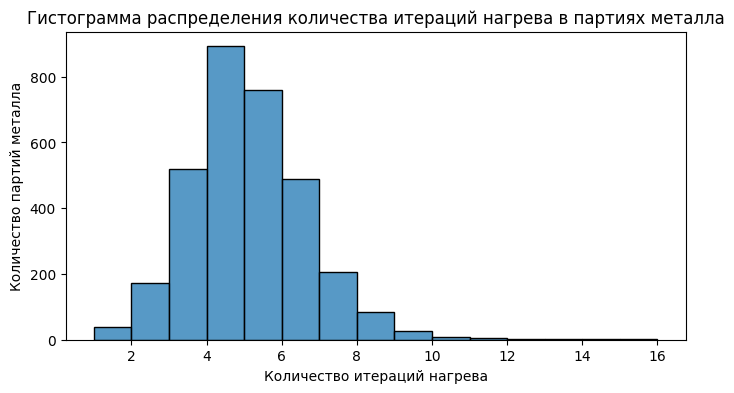

In [24]:
# viz
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
sns.histplot(arc['key'].value_counts(), bins=15)
plt.title('Гистограмма распределения количества итераций нагрева в партиях металла')
plt.xlabel('Количество итераций нагрева')
plt.ylabel('Количество партий металла')
plt.show()

Видим, что преобладают партии металла с 3-6 итерациями нагрева. Больше всего партий с 4 итерациями

Выведем также распределение активной и реактивной мощностей:

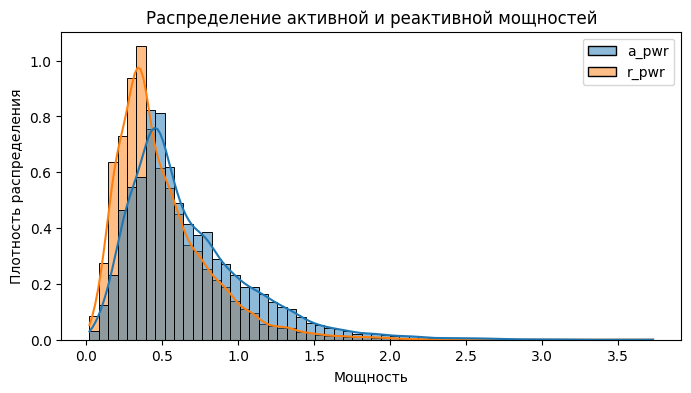

In [25]:
# viz
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
sns.histplot(arc[['a_pwr', 'r_pwr']], bins=60, stat='density', kde=True, alpha=0.5)
plt.title('Распределение активной и реактивной мощностей')
plt.xlabel('Мощность')
plt.ylabel('Плотность распределения')
plt.show()

Распределения активной и реактивной мощности имеют форму нормальных распределений, немного скошенных вправо и обрезанных в нулевой точке

Данные графики распределений лишний раз – теперь уже наглядно – подтверждают линейную взаимосвязь активной и реактивной мощности. Для дальнейшего моделирования мультиколлинеарность – это определённая проблема и использовать оба данных признака в обучении модели нельзя

Пропущенных значений в датафрейме нет, однако, выясним, для каждой ли партии металла у нас есть данные по нагреву. Минимальное значение номера партии равно 1, а максимальное – 3241, проверим, сколько и каких именно номеров нет в списке уникальных значений `key` датафрейма `arc`:

In [26]:
# список номеров партий, для которых нет данных по нагреву
no_key_lst = [i for i in range(1, 3242) if i not in arc['key'].unique()]

# out
head_print(f"В датафрейме `arc` отсутствует {len(no_key_lst)} номеров партий металла, а именно:", 0)
print(', '.join(map(str, no_key_lst)))

В датафрейме `arc` отсутствует 27 номеров партий металла, а именно:
41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207


**Предварительные выводы:**

- Само по себе время включения и выключения дуги нагрева для модели бесполезно, однако интервал времени, в течение которого происходил нагрев, может стать хорошим признаком. То есть, нужно будет добавить столбец с разницей между временем отключения нагрева и временем его включения
- Кроме того, вероятно, для дальнейшего моделирования имеет смысл учитывать суммарный нагрев сплава. Таким образом, при подготовке рабочего датафрейма для модели необходимо будет просуммировать временные интервалы нагрева и мощности по всем итерациям для каждой партии. Иными словами, сгруппировать датафрейм по партиям с суммирующей агрегирующей функцией
- Также необходимо решить проблему мультиколлинеарности признаков

<br><br>

## 1.4. Датафреймы `bulk` и `bulk_time` (предобработка, EDA)

Для начала убедимся, что датафреймы `bulk` и `bulk_time` совпадают по пропущенным значениям (и, соответственно, по количеству строк и столбцов):

In [27]:
# out
head_print('Пропущенные значения в датафреймах `bulk` и `bulk_time` ' 
           + f"{'полностью' if (bulk.isna() == bulk_time.isna()).all().all() else 'НЕ'} совпадают", 0)

Пропущенные значения в датафреймах `bulk` и `bulk_time` полностью совпадают


Исходя из сути технологического процесса в конечном итоге мы имеем сплав, содержащий определённые добавки некоторых материалов. Для модели машинного обучения не важно, в какое время они были внесены в сплав, главное, что они были добавлены в определенных количествах. Таким образом нас в первую очередь интересует предобработка датафрейма `bulk` с объёмами добавленных материалов. Сопутствующий датафрейм `bulk_time` пока не рассматриваем

Приведём названия столбцов датафрейма `bulk` к нотации snake_case:

In [28]:
# количество столбцов bulk
bulk_count = 15

# изменим названия столбцов
bulk_columns = ['key'] + ['bulk_' + str(i+1) for i in range(bulk_count)]
bulk.columns = bulk_columns

Отобразим диаграммы размаха для количества (объёма) каждой из 15 добавок:

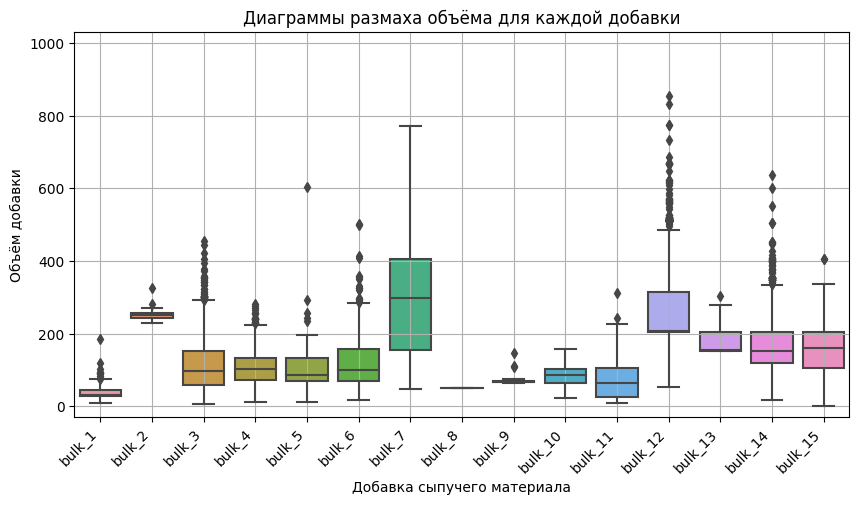

In [29]:
# viz
plt.figure(figsize=(10, 5))
sns.boxplot(data=bulk.iloc[:, 1:])
plt.title('Диаграммы размаха объёма для каждой добавки')
plt.xlabel('Добавка сыпучего материала')
plt.ylabel('Объём добавки')
plt.ylim(-30, 1030)
plt.xticks(rotation=45, ha='right')
plt.grid()

Видим, что в основном добавки подмешиваются в небольших диапазонах значений объёма, преимущественно от 0 до 200. Некоторые варьируются уже в диапазоне значений 200-400, с достаточно широким распределением (bulk_7 и bulk_12). А некоторые (например, bulk_8) вообще имеют всего один случай применения – для модели ML такой признак будет бесполезен

Теперь займёмся пропущенными значениями. Очевидно, пропуски в данных обусловлены спецификой технологического процесса: разные материалы примешиваются к сплаву в разное время. Заменим пропуски в датафрейме `bulk` нулевыми значениями. Также приведём все столбцы к целочисленному типу данных:

In [30]:
# приведём все столбцы к целочисленному типу данных
bulk = bulk.fillna(0).astype('int64')

Выведем результат (первые 2 строки):

In [31]:
# out
head_print('Первые 2 строки датафрейма `bulk`:', 0)
bulk.head(2)

Первые 2 строки датафрейма `bulk`:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154


Выясним, для каждой ли партии металла у нас есть данные по внесенным добавкам. Проверим, сколько и каких именно номеров партий нет в списке уникальных значений `key` датафрейма `bulk`:

In [32]:
# список номеров партий, для которых нет данных по сыпучим добавкам
no_key_lst = [i for i in range(1, 3242) if i not in bulk['key'].unique()]

# out
head_print(f"В датафрейме `bulk` отсутствует {len(no_key_lst)} номеров партий металла, а именно:", 0)
print(', '.join(map(str, no_key_lst)))

В датафрейме `bulk` отсутствует 112 номеров партий металла, а именно:
41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216


**Предварительные выводы:**

- Для модели имеет значение скорее количество добавленных сыпучих материалов. А время их добавления можно исключить из признаков
- Вероятно, из 15 добавок наименьшую роль в модели будут играть те материалы, по которым меньше всего данных (как минимум, bulk_8)

<br><br>

## 1.5. Датафрейм `gas` (предобработка, EDA)

Приведём названия столбцов датафрейма `gas` к нотации snake_case и выведем результат (первые 2 строки):

In [33]:
# изменим названия столбцов
gas.columns = ['key', 'gas']

# out
head_print('Первые 2 строки датафрейма `gas`:', 0)
gas.head(2)

Первые 2 строки датафрейма `gas`:


,key,gas
0,1,29.749986
1,2,12.555561


Визуализируем распределение объёма инертного газа для продувки сплава:

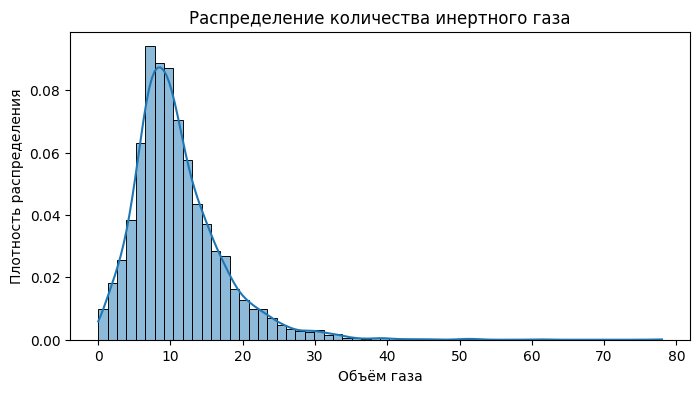

In [34]:
# viz
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
sns.histplot(gas['gas'], bins=60, stat='density', kde=True, alpha=0.5)
plt.title('Распределение количества инертного газа')
plt.xlabel('Объём газа')
plt.ylabel('Плотность распределения')
plt.show()

Распределение объёмов инертного газа имеет форму нормального распределения, обрезанного в нулевой точке (отрицательного количества газа быть не может). Если посмотреть на основные статистики для этого параметра, видим, что среднее (11) чуть больше медианы (9.8). Половина всех значений сосредоточена в интервале 7-14, однако, встречаются и значения превышающие несколько десятков (достигают до 78) – они-то немного и скашивают распределение вправо

Выясним, для каждой ли партии металла у нас есть данные по продувке инертным газом. Проверим, сколько и каких именно номеров партий нет в списке уникальных значений `key` датафрейма `gas`:

In [35]:
# список номеров партий, для которых нет данных по продувке газом
no_key_lst = [i for i in range(1, 3242) if i not in gas['key'].unique()]

# out
head_print(f"В датафрейме `gas` отсутствует {len(no_key_lst)} номера партий металла, а именно:", 0)
print(', '.join(map(str, no_key_lst)))

В датафрейме `gas` отсутствует 2 номера партий металла, а именно:
193, 259


**Предварительные выводы:**

- Данные в порядке, можем использовать в качестве признаков для модели машинного обучения

<br><br>

## 1.6. Датафрейм `temp` (предобработка, EDA)

Приведём названия столбцов датафрейма `temp` к нотации snake_case, преобразуем тип столбца, содержащего дату и время к типу datetime и выведем результат (первые 2 строки):

In [36]:
# изменим названия столбцов
temp.columns = ['key', 'time_temp', 'temp']

# приведение типа столбцов даты-времени к datetime64
temp['time_temp'] = pd.to_datetime(temp['time_temp'])

# out
head_print('Первые 2 строки датафрейма `temp`:', 0)
temp.head(2)

Первые 2 строки датафрейма `temp`:


,key,time_temp,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0


Выведем гистограмму распределения количества итераций измерения температуры в партиях металла:

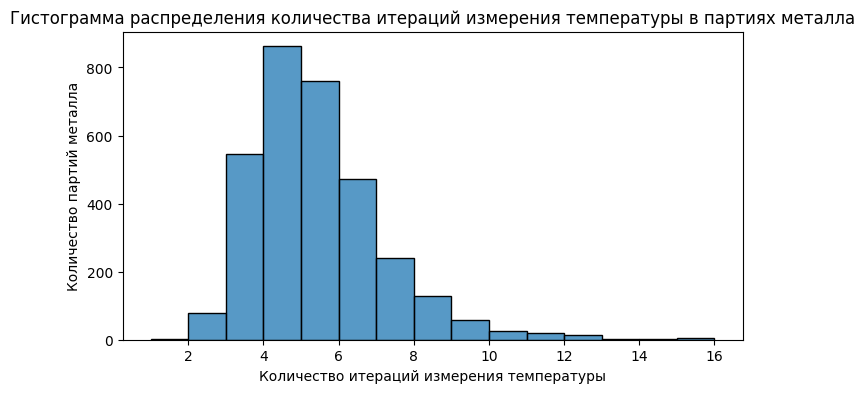

In [37]:
# viz
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
sns.histplot(temp['key'].value_counts(), bins=15)
plt.title('Гистограмма распределения количества итераций измерения температуры в партиях металла')
plt.xlabel('Количество итераций измерения температуры')
plt.ylabel('Количество партий металла')
plt.show()

Видим, что преобладают партии металла с 3-6 итерациями измерения температуры. Больше всего партий с 4 итерациями. Что, в принципе, перекликается с итерациями нагрева в датафрейме `arc`

Выведем также распределение температуры:

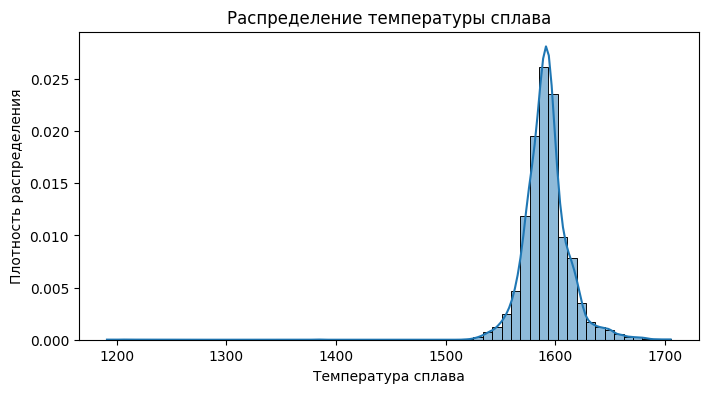

In [38]:
# viz
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
sns.histplot(temp['temp'], bins=60, stat='density', kde=True, alpha=0.5)
plt.title('Распределение температуры сплава')
plt.xlabel('Температура сплава')
plt.ylabel('Плотность распределения')
plt.show()

Распределение температуры сплава имеет форму нормального распределения со средним значением 1591 градус. Среднее значение совпадает с медианным значением, что говорит о симметричности (нескошенности) распределения. Стандартное отклонение всего в 21 градус указывает на то, что большая часть значений (~68%) лежит в пределах узкого диапазона от 1570-1612 градусов

Выведем количество пропущенных значений температуры:

In [39]:
# out
head_print(f"Количество пропущенных значений температуры в датафрейме `temp`: {temp['temp'].isna().sum()}", 0)

Количество пропущенных значений температуры в датафрейме `temp`: 2901


Выясним, в каких партиях металла встречаются пропуски и сколько таких партий:

In [40]:
keys_nan_temp = temp.loc[temp['temp'].isna(), 'key'].unique()

# out
head_print(f"{len(keys_nan_temp)} партий металла в датафрейме `temp` содержат пропущенные значения температуры, а именно:", 0)
print(', '.join(list(map(str, keys_nan_temp[:5])) + ['..........'] + list(map(str, keys_nan_temp[-5:]))))

739 партий металла в датафрейме `temp` содержат пропущенные значения температуры, а именно:
2500, 2501, 2502, 2503, 2504, .........., 3237, 3238, 3239, 3240, 3241


Учитывая количество 2901 пропусков, получаем, в среднем 4 пропущенных значения температуры на каждую из 739 партий. Разберёмся, в чём дело, выведем первые 10 итераций в этих партиях, начиная с 2500-й:

In [41]:
# out
head_print('Первые 10 итераций измерения температуры, начиная с 2500-й партии металла:', 0)
temp[temp['key'].isin(keys_nan_temp)].head(10)

Первые 10 итераций измерения температуры, начиная с 2500-й партии металла:


,key,time_temp,temp
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12276,2502,2019-08-06 04:45:26,1583.0


Очевидно, мы столкнулись с результатом какого-то сбоя в записи значений температуры. Насколько можно судить по первым нескольким исследованным партиям из этого списка, в каждой из них записана только начальная температура металла. Возможно на 2500-й партии вышел из строя датчик, или возникла ошибка при переносе данных. Так или иначе, пропущенные значения нам восстановить никак не удастся – ведь их наоборот нужно предсказать и с хорошей точностью. Придётся их удалить

Очевидно, после удаления пропусков большая часть партий металла останется только с начальной температурой сплава. И эти партии также отсеятся уже на этапе подготовки выборки для обучения моделей. Ведь, как сообщил заказчик, у каждой партии металла должны быть как минимум начальная и конечная температура (таргет)

In [42]:
# удалим пропуски температуры в датафрейме `temp`
temp = temp.dropna(subset=['temp'])

# приведём значения температуры к целочисленному типу данных
temp['temp'] = temp['temp'].astype('int64')

Традиционно, выясним, для каждой ли партии металла у нас есть данные по замерам температуры (хотя бы одному). Проверим, сколько и каких именно номеров партий нет в списке уникальных значений `key` датафрейма `temp`:

In [43]:
# список номеров партий, для которых нет данных по замерам температуры
no_key_lst = [i for i in range(1, 3242) if i not in temp['key'].unique()]

# out
head_print(f"В датафрейме `temp` отсутствует {len(no_key_lst)} номеров партий металла, а именно:", 0)
print(', '.join(map(str, no_key_lst)))

В датафрейме `temp` отсутствует 25 номеров партий металла, а именно:
41, 42, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207


**Предварительные выводы:**

- В рамках подготовки выборки для обучения моделей необходимо будет выделить в каждой партии только начальную температуру и конечную температуру металла (целевой признак). Иными словами, сгруппировать датафрейм `temp` по номеру партии с агрегирующими функциями первого и последнего значения (first и last)
- В выборку, соответственно, должны войти только те партии металла, в которых есть не менее двух измерений температуры

<br><br>

## 1.7. Датафреймы `wire` и `wire_time` (предобработка, EDA)

Для начала убедимся, что датафреймы `wire` и `wire_time` совпадают по пропущенным значениям (и, соответственно, по количеству строк и столбцов):

In [44]:
# out
head_print('Пропущенные значения в датафреймах `wire` и `wire_time` ' 
           + f"{'полностью' if (wire.isna() == wire_time.isna()).all().all() else 'НЕ'} совпадают", 0)

Пропущенные значения в датафреймах `wire` и `wire_time` полностью совпадают


Для проволочных материалов (по аналогии с сыпучими материалами добавок) также считаем, что для модели ML не важно, в какое время они были внесены в сплав, но важно их количество. Таким образом нас в первую очередь интересует предобработка датафрейма `wire` с объёмами добавленных материалов. Сопутствующий датафрейм `wire_time` не рассматриваем

Приведём названия столбцов датафрейма `wire` к нотации snake_case:

In [45]:
# количество столбцов wire
wire_count = 9

# изменим названия столбцов
wire_columns = ['key'] + ['wire_' + str(i+1) for i in range(wire_count)]
wire.columns = wire_columns

Отобразим диаграммы размаха для количества (объёма) каждой из 9 добавок:

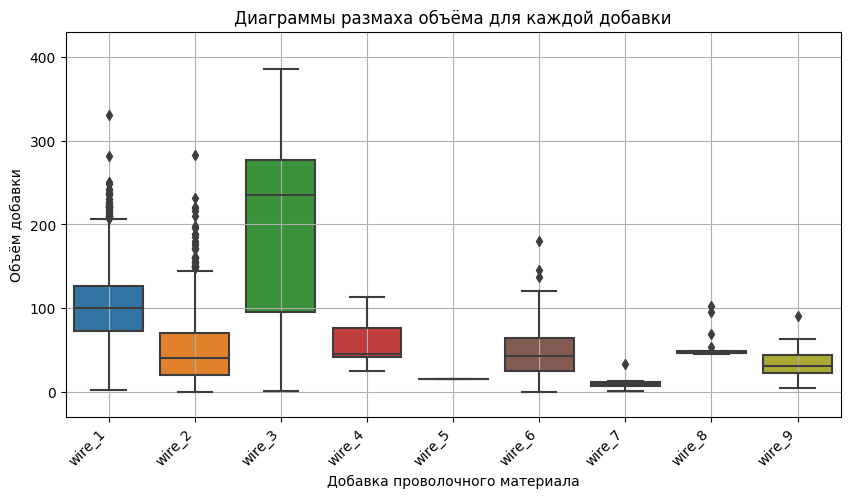

In [46]:
# viz
plt.figure(figsize=(10, 5))
sns.boxplot(data=wire.iloc[:, 1:])
plt.title('Диаграммы размаха объёма для каждой добавки')
plt.xlabel('Добавка проволочного материала')
plt.ylabel('Объём добавки')
plt.ylim(-30, 430)
plt.xticks(rotation=45, ha='right')
plt.grid()

Видим, что в основном добавки подмешиваются в небольших диапазонах значений объёма, преимущественно от 0 до 100. Некоторые варьируются уже в диапазоне значений 0-200 (wire_1), некоторые – от 100 до 300, с достаточно широким распределением (wire_3). А некоторые (например, wire_5) вообще имеют всего один случай применения – для модели ML такой признак будет бесполезен

Теперь займёмся пропущенными значениями. Очевидно, пропуски в данных обусловлены спецификой технологического процесса: разные материалы примешиваются к сплаву в разное время. Заменим пропуски в датафрейме `wire` нулевыми значениями:

In [47]:
wire = wire.fillna(0)

Выведем результат (первые 2 строки):

In [48]:
# out
head_print('Первые 2 строки датафрейма `wire`:', 0)
wire.head(2)

Первые 2 строки датафрейма `wire`:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Выясним, для каждой ли партии металла у нас есть данные по внесенным добавкам. Проверим, сколько и каких именно номеров партий нет в списке уникальных значений `key` датафрейма `wire`:

In [49]:
# список номеров партий, для которых нет данных по проволочным добавкам
no_key_lst = [i for i in range(1, 3242) if i not in wire['key'].unique()]

# out
head_print(f"В датафрейме `wire` отсутствует {len(no_key_lst)} номеров партий металла, а именно:", 0)
print(', '.join(map(str, no_key_lst)))

В датафрейме `wire` отсутствует 160 номеров партий металла, а именно:
41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 2849, 2850, 2863, 2871, 2872, 2873, 2874, 2875, 2876, 3035, 3036, 3037, 3038, 3039, 3040, 3200, 3207


**Предварительные выводы:**

- Для модели имеет значение скорее количество добавленных проволочных материалов. А время их добавления можно исключить из признаков
- Вероятно, из 9 добавок наименьшую роль в модели будут играть те материалы, по которым меньше всего данных (как минимум, wire_5)

<br><br>

## 1.8. Вопросы заказчику

На встрече с представителем заказчика была прояснена ситуация по следующим вопросам:

- Необходима фиксация сидов для воспроизводимости результатов. Использовать константу RANDOM_STATE = 270323
- Наш целевой признак – конечная температура металла из всех доступных замеров для партии
- Метрика для оценки качества модели – MAE
- Критерий качества модели – MAE не более 6.8
- Оценку качества проводить на кросс-валидации. Тестовая выборка – только для тестирования итоговой модели
- Использовать разделение данных на обучающую и тестовую выборки в соотношении 3:1
- Обязательно использовать начальную температуру металла, как один из признаков. Таким образом нас интересуют только партии, где имеется не менее двух результатов замера температуры
- Промежуточные измерения температуры в качестве признаков не использовать
- Временны́е данные для моделирования не использовать, в связи с рассинхронизацией протоколирования технологических процессов
- Использовать в моделировании только те партии, по которым есть полный набор технологических операций (сыпучие и проволочные добавки, продувка газом, нагрев и минимум две измеренные температуры)
- По результатам работы заказчик также хочет получить оценку значимости признаков

На данный момент есть полная ясность по задаче, дополнительных обсуждений пока не требуется

<br><br>

## 1.9. Подведение итогов изучения и предобработки данных

Итак, в ходе загрузки и предобработки данных было выполнено следующее:

- Во всех датафреймах исправлены названия столбцов
- Типы данных приведены в соответствие
- Дубликатов  не выявлено
- Обнаружено и исправлено аномальное значение реактивной мощности в датафрейме `arc`
- Пропущенные значения в датафреймах `bulk` и `wire` заменены на нулевые
- Удалены пропуски в замерах температуры датафрейма `temp`

<br>

В ходе исследовательского анализа данных, а также в ходе уточнения у заказчика деталей задания и технологического процесса, были сделаны следующие выводы:

- Абсолютные временны́е данные для моделирования использовать нельзя, однако хорошим признаком может стать относительный временной интервал нагрева металла дугой
- Преобладают партии металла с 3-6 итерациями нагрева и измерения температуры. Больше всего партий с 4 итерациями
- Очевидно, в итоговой выборке для обучения моделей необходимо избавиться от итераций в партиях, так как в основном они опираются на хронологию технологических операций, но, как мы выяснили, опираться на временны́е данные в нашем случае нельзя
- Итерации в замерах температуры автоматически сокращаются до начального и конечного значений для каждой партии. Соответственно, в выборку войдут только партии металла с 2 и более замерами температуры в датафрейме `temp`
- Что касается итераций по нагреву, лучшим решением пока видится группировка и агрегирование (суммирующей функцией) значений мощности и интервала времени нагрева в каждой партии. Таким образом мы учитываем в признаках итоговое воздействие на сплав (суммарной мощностью нагрева в течение совокупного интервала времени)
- Поскольку была выявлена высокая корреляция активной и реактивной мощностей, необходимо выбрать или активную мощность, как непосредственное воздействие на металл, либо вычислить общую мощность. Оставим это до этапа сборки основной выборки для обучения моделей. Там же проведём обязательную итоговую проверку на мультиколлинеарность признаков
- В ходе исследования данных было выявлено, что во всех датафреймах отсутствуют данные по некоторым партиям металла. Судя по спискам номеров, часть партий отсутствует практически во всех датафреймах
- Так или иначе обязательным условием заказчика является использование только тех партий, для которых есть данные по всем без исключения технологическим процессам. Таким образом будем использовать inner-объединение датафреймов по ключу `key`

<br>

На основании проделанного исследования и полученных выводов актуализируем план работ:

<br><br>

## 1.10. План работ

1. Загрузить данные, провести их предобработку и исследовательский анализ
    - Загрузить данные
    - Провести первичное знакомство с данными, наметить план для предобработки
    - Провести предобработку и исследовательский анализ данных
    - Получить разъяснения от заказчика по поводу задания и технологического процесса
    - Подвести итоги изучения данных и наметить пути решения задачи
    - Актуализировать план работ
<br>

2. Разработать модель машинного обучения
    - Подготовить и объединить данные для обучения моделей в единый датафрейм
    - Провести краткий исследовательский анализ нового датафрейма, провести проверку на мультиколлинеарность, определиться с признаками
    - Разделить данные на обучающую и тестовые выборки 3:1
    - Построить, испытать и сравнить несколько моделей машинного обучения
    - Провести анализ моделей, выбрать лучшую, соответствующую поставленной задаче
    - Испытать лучшую модель на тестовой выборке, а также проверить её на адекватность в сравнении с константной моделью
    - Получить оценку значимости признаков
    - Подвести итоги разработки модели
<br>

3. Подготовить отчёт о проделанной работе
    - Подготовить для заказчика подробное описание исследования
    - Отразить основные выводы и решения, обозначить промежуточные и итоговый результаты


<br><br><br><br>

# 2. Разработка модели машинного обучения

## 2.1. Подготовка итогового датафрейма `df`

Итак, нам необходимо избавиться от итераций в партиях, так как мы не можем опираться на временны́е ряды в данной задаче. Для этого мы решили сгруппировать по номеру партии датафреймы с итерациями (`arc` и `temp`). Из датафрейма `arc` мы хотим получить данные о суммарной общей мощности и совокупном временном интервале нагрева. А из датафрейма `temp` начальную и конечную температуры металла. Приступим:

Создадим новый датафрейм `arc_sum`, добавим в нём столбец с общей мощностью и с интервалом нагрева и просуммируем все признаки по итерациям для каждой партии металла. Выведем первые две строчки получившегося датафрейма:

In [50]:
# создаем новый датафрейм `arc_sum` из 3 столбцов `arc`
arc_sum = arc[['key', 'a_pwr', 'r_pwr']]

# добавляем столбец с общей мощностью
arc_sum['power'] = (arc_sum['a_pwr']**2 + arc_sum['r_pwr']**2)**0.5

# добавляем столбец с интервалом нагрева
arc_sum['time'] = (arc['time_arc_off'] - arc['time_arc_on']).dt.seconds

# группируем по номеру партии, агрегируем суммой
arc_sum = arc_sum.groupby('key').sum().reset_index()

# out
arc_sum.head(2)

,key,a_pwr,r_pwr,power,time
0,1,4.878147,3.183241,5.826395,1098
1,2,3.052598,1.998112,3.649216,811


В новом датафрейме с температурами `temps` сначала отфильтруем и оставим те партии, в которых как минимум две итерации. Затем выделим первое и последнее значения замеров температуры. Выведем первые две строчки получившегося датафрейма:

In [51]:
# количество итераций для каждой партии
temp_keys = temp['key'].value_counts()

# создаем список номеров партий с >1 итераций
temp_keys = temp_keys[temp_keys>1].index

# создаем новый датафрейм `temps` из среза `temp`: только >1 итерации для каждой партии, только 2 столбца
temps = temp.loc[temp['key'].isin(temp_keys), ['key', 'temp']]

# группируем по номеру партии, выбираем из итераций только первый и последний замер температуры
temps = temps.groupby('key').agg(['first', 'last']).reset_index()

# переименовываем столбцы
temps.columns = ['key', 'temp_0', 'temp']

# out
temps.head(2)

,key,temp_0,temp
0,1,1571,1613
1,2,1581,1602


Теперь можем объединить все датафреймы с данными в единый датафрейм `df`. Объединяем только по тем партиям, для которых есть данные обо всех технологических процессах (т.е. используем при объединении метод inner):

In [52]:
# объединяем все данные в один датафрейм `data`
df = (temps
      .merge(arc_sum, how='inner', on='key')
      .merge(gas, how='inner', on='key')
      .merge(bulk, how='inner', on='key')
      .merge(wire, how='inner', on='key'))

Исследуем новый получившийся датафрейм:

<br><br>

## 2.2. Краткий исследовательский анализ `df`

Выведем основную информацию о датафрейме `df`:

In [53]:
# out
show_df_info(df, 'df')


Датафрейм `df`: Объединённые данные технологических процессов.   (Строк: 2329, столбцов: 32)
————————————————————————————————————————————————————————————————————————————————————————————————————

Информация о столбцах:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 32 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      2329 non-null   int64  
 1   temp_0   2329 non-null   int64  
 2   temp     2329 non-null   int64  
 3   a_pwr    2329 non-null   float64
 4   r_pwr    2329 non-null   float64
 5   power    2329 non-null   float64
 6   time     2329 non-null   int64  
 7   gas      2329 non-null   float64
 8   bulk_1   2329 non-null   int64  
 9   bulk_2   2329 non-null   int64  
 10  bulk_3   2329 non-null   int64  
 11  bulk_4   2329 non-null   int64  
 12  bulk_5   2329 non-null   int64  
 13  bulk_6   2329 non-null   int64  
 14  bulk_7   2329 non-null   int64  
 15  bulk_8   2329 non-null

,key,temp_0,temp,a_pwr,r_pwr,power,time,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571,1613,4.878147,3.183241,5.826395,1098,29.749986,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581,1602,3.052598,1.998112,3.649216,811,12.555561,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596,1599,2.525882,1.599076,2.989534,655,28.554793,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601,1625,3.209250,2.060298,3.814962,741,18.841219,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576,1602,3.347173,2.252643,4.035758,869,5.413692,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Количество дубликатов: 0

Основные статистики:


,count,mean,std,min,25%,50%,75%,max
key,2329.0,1251.832546,714.762400,1.000000,630.000000,1255.000000,1868.000000,2499.000000
temp_0,2329.0,1586.718763,28.290792,1191.000000,1571.000000,1587.000000,1603.000000,1660.000000
temp,2329.0,1593.365393,11.200915,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
a_pwr,2329.0,3.152449,1.425290,0.186226,2.173277,3.028334,3.920676,17.496497
r_pwr,2329.0,2.351210,1.081639,0.158247,1.626854,2.234997,2.915089,12.587990
power,2329.0,3.941933,1.779229,0.257637,2.735080,3.773603,4.892791,21.564771
time,2329.0,807.647488,340.838388,57.000000,581.000000,778.000000,993.000000,4189.000000
gas,2329.0,11.375600,6.392041,0.008399,7.282948,10.100950,14.216688,77.995040
bulk_1,2329.0,3.427651,12.412132,0.000000,0.000000,0.000000,0.000000,185.000000
bulk_2,2329.0,1.422499,19.082119,0.000000,0.000000,0.000000,0.000000,325.000000


Итак:
- Мы имеем совокупную информацию по 2329 партиям металла
- В датафрейме `df` 32 столбца, содержащие данные по различным технологическим операциям. Среди них есть целевой признак `temp`
- Пропусков в данных нет
- Явных дубликатов также нет
- Каких-либо аномальных значений не замечено

Проверим признаки на мультиколлинеарность, выведем тепловую карту значений коэффициентов корреляции Пирсона:

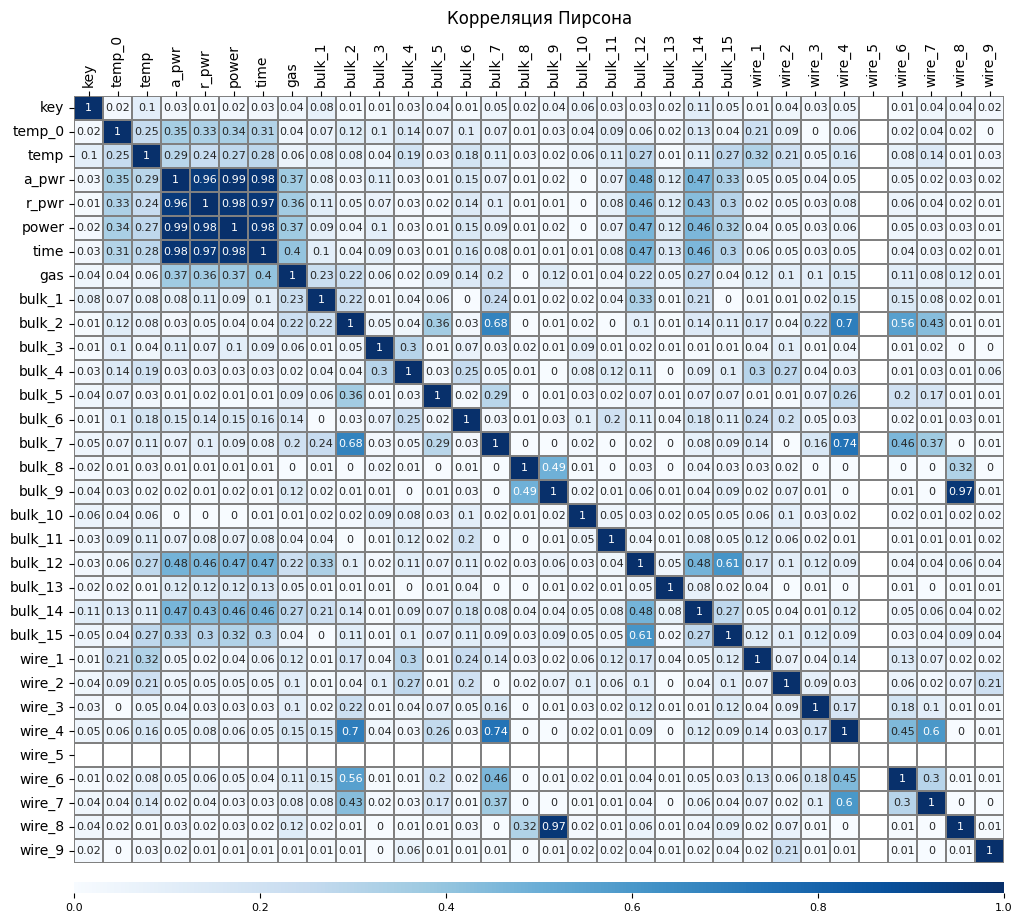

In [54]:
# исследуем корреляцию признаков
# viz
fig, ax = plt.subplots(figsize=(12, 12))
ax.xaxis.tick_top()
plt.rcParams.update({'font.size': 8})
sns.heatmap(round(abs(df.corr()), 2), annot=True, cmap='Blues', linewidths=0.1, linecolor='grey',
            cbar_kws={'location': 'bottom', 'aspect': 80, 'pad': 0.02})
plt.title('Корреляция Пирсона', fontsize=12)
plt.yticks(rotation=0)
plt.show()

Видим, что ожидаемо и очень сильно коррелируют между собой значения активной, реактивной, общей мощностей и времени нагрева. Оставим в качестве признака только какой-то один, например, общую мощность

Также видим, что в процессе объединения мы потеряли ту единственную партию металла, в которой была добавка wire_5. Кроме того, отмечаем сильную взаимосвязь между признаками wire_8 и bulk_9. Скорее всего это ошибочная корреляция вызванная малым количеством данных в этих столбцах (всего по 9 записей). Оставим один из них, например, wire_8

За исключением вышеописанных наблюдений отмечаем, что в остальных признаках корреляция не наблюдается, либо выражена незначительно

Также для моделей машинного обучения не имеет смысла номер партии `key`

Удалим нежелательные столбцы из датафрейма `df`:

In [55]:
# удалим номер партии и коррелирующие признаки
df = df.drop(['key', 'a_pwr', 'r_pwr', 'time', 'bulk_9', 'wire_5'], axis=1)

Раньше мы изучали распределение температуры по всем итерациям. Рассмотрим теперь то же распределение, но только для начальной и конечной температуры:

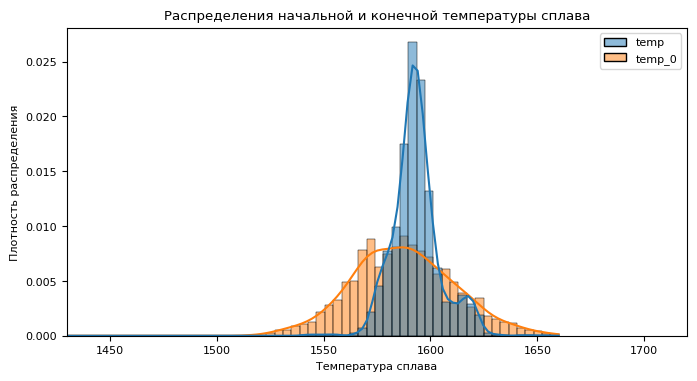

In [56]:
# viz
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
sns.histplot(df[['temp', 'temp_0']], bins=120, stat='density', kde=True, alpha=0.5)
plt.title('Распределения начальной и конечной температуры сплава')
plt.xlabel('Температура сплава')
plt.xlim(1430, 1720)
plt.ylabel('Плотность распределения')
plt.show()

Видим, что в целом графики по-прежнему имеют формы нормального распределения. Для начальной температуры характерен больший разброс значений и небольшое смещение среднего значения, относительно конечной температуры, что логично и объяснимо отличиями "рецептуры" для различных партий. Каждая из партий имеет разлиную начальную температуру, обусловленную отличиями в тех.процессе, однако "готовый продукт", как правило имеет более стабильную температуру

Выведем также распределение суммарной мощности:

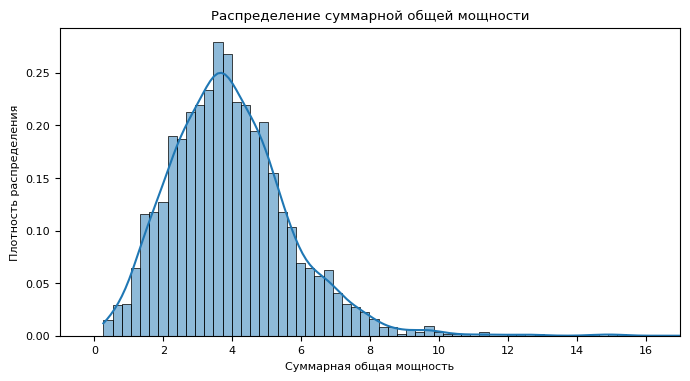

In [57]:
# viz
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
sns.histplot(df['power'], bins=80, stat='density', kde=True, alpha=0.5)
plt.title('Распределение суммарной общей мощности')
plt.xlabel('Суммарная общая мощность')
plt.xlim(-1, 17)
plt.ylabel('Плотность распределения')
plt.show()

Наблюдаем похожую картину нормального распределения, как и в графиках распределения итерационных активной и реактивной мощностей. Отличия лишь в увеличенных значениях суммарной мощности

В целом датафрейм `df` полностью готов к использованию в обучении моделей

<br><br>

## 2.3. Разделение датафрейма на выборки, масштабирование данных

Выделим отдельно фичи и целевой признак, разобьём данные на обучающую и тестовую выборки в соотношении 3:1 (75/25):

In [58]:
# выделяем фичи и таргет
X = df.drop(['temp'], axis=1)
y = df['temp']

# разделяем на обучающую и тестовую выборки 3:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RND)

Обратим внимание, что масштабирование данных не является обязательным при использовании в задаче регрессии "деревянных" моделей, таких как дерево решений, или моделей, построенных на ансамблях деревьев – случайный лес, catboost, lgbm. Все эти модели отлично работают с нелинейными зависимостями и не требуют предварительной нормализации данных

Для линейной регрессии желательно масштабировать данные. Однако в дальнейшем мы планируем использовать кросс-валидацию для оценки качества модели. В этом случае для избежания утечки данных масштабирование нужно проводить непосредственно в процессе кросс-валидации. Для этой цели можно использовать пайплайны, что и будет реализовано чуть позже

Подготовим функцию для вывода результатов подбора параметров моделей:

In [59]:
def show_search_results(model, params, score):
    head_print(f'Модель: {model}', 80)
    head_print(f'Лучшие параметры: {params}', 0)
    head_print(f'MAE = {round(score, 3)}', 0)
    print()

Обучим несколько моделей, от самых простых, типа линейной регрессии и дерева решений, до ансамблей и бустингов, типа случайного леса и LGBM. Для каждой модели подберём оптимальные гиперпараметры:

<br><br>

## 2.4. Обучение моделей

### 2.4.1. Модель LinearRegression


Итак, для модели линейной регрессии мы проверим, есть ли эффект и улучшение качества модели от масштабирования данных. Будем применять его в пайплайне, для избежания утечки

В принципе, в ходе исследовательского анализа мы убедились, что все имеющиеся у нас данные в большинстве своём подчиняются нормальному закону распределения. Таким образом в нашем случае, подойдёт стандартизация (StandardScaler). Нормализация (MinMaxScaler) полезна, когда данные имеют разные масштабы и мы ничего не знаем о распределении данных, или когда предполагаем, что распределение возможно не является гауссовым. В случае, если есть значительные отклонения, полезен метод RobustScaler(). В исследовательских целях мы рассмотрим все три типа масштабирования данных, а также вариант без масштабирования

Подберем для LinearRegression наилучшие гиперпараметры и рассчитаем метрику MAE на кросс-валидации:

In [60]:
%%time

# создадим пайплайн
lr_pipeline = Pipeline([
    ('scaler', FunctionTransformer(func=lambda x: x)),
    ('estim', LinearRegression())])

# параметры для перебора, в т.ч. 4 вида скейлеров
lr_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), FunctionTransformer(func=lambda x: x)],
    'estim__fit_intercept': [True, False]}

# подбор гиперпараметров и обучение
lr_search = GridSearchCV(lr_pipeline, lr_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
lr_search.fit(X_train, y_train)

# лучший скор, модель и её параметры
lr_score = -lr_search.best_score_
lr_model = lr_search.best_estimator_
lr_params = lr_search.best_params_

# out
show_search_results('LinearRegression', lr_params, lr_score)

Модель: LinearRegression
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'estim__fit_intercept': True, 'scaler': FunctionTransformer(func=<function <lambda> at 0x000001D76D5672E0>)}
MAE = 7.132

CPU times: total: 234 ms
Wall time: 3.04 s


В ходе проверки было установлено, что в нашем случае масштабирование данных не дало никакого результата. Модели отработали с одинаковым значением метрики для всех используемых скейлеров, включая вариант без масштабирования. Вероятно это связано с небольшими значениями признаков, малым их разбросом и нормальным распределением

<br>

### 2.4.2. Модель DecisionTreeRegressor

Подберем для DecisionTreeRegressor наилучшие гиперпараметры и рассчитаем метрику MAE на кросс-валидации:

In [61]:
%%time

# модель
dt_estimator = DecisionTreeRegressor(random_state=RND)

# определяем параметры для перебора
dt_params = {'max_depth': range(15)}

# подбор гиперпараметров и обучение
dt_search = GridSearchCV(dt_estimator, dt_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
dt_search.fit(X_train, y_train)

# лучший скор, модель и её параметры
dt_score = -dt_search.best_score_
dt_model = dt_search.best_estimator_
dt_params = dt_search.best_params_

# out
show_search_results('DecisionTreeRegressor', dt_params, dt_score)

Модель: DecisionTreeRegressor
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'max_depth': 5}
MAE = 7.31

CPU times: total: 203 ms
Wall time: 1.05 s


<br>

### 2.4.3. Модель RandomForestRegressor

Подберем для RandomForestRegressor наилучшие гиперпараметры и рассчитаем метрику MAE на кросс-валидации:

In [62]:
%%time

# модель
rf_estimator = RandomForestRegressor(random_state=RND)

# определяем параметры для перебора
# сначала: 'n_estimators': range(80, 241, 20)  # best 200
# rf_params = {'max_depth': range(9, 13), 'n_estimators': [190, 200, 210], 
#              'min_samples_leaf': range(1, 7), 'min_samples_split': range(2, 7)}  # best 10, 200, 1, 2
rf_params = {'max_depth': [10], 'n_estimators': [200], 'min_samples_leaf': [1], 'min_samples_split': [2]}

# подбор гиперпараметров и обучение
rf_search = GridSearchCV(rf_estimator, rf_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
rf_search.fit(X_train, y_train)

# лучший скор, модель и её параметры
rf_score = -rf_search.best_score_
rf_model = rf_search.best_estimator_
rf_params = rf_search.best_params_

# out
show_search_results('RandomForestRegressor', rf_params, rf_score)

Модель: RandomForestRegressor
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE = 6.291

CPU times: total: 9.77 s
Wall time: 27.2 s


<br>

### 2.4.4. Модель LGBMRegressor

Подберем для LGBMRegressor наилучшие гиперпараметры и рассчитаем метрику MAE на кросс-валидации:

In [63]:
%%time

# модель
lgbm_estimator = LGBMRegressor(random_state=RND, verbose=-1)

# определяем параметры для перебора
# lgbm_params = {'max_depth': range(9, 16), 'n_estimators': range(100, 201, 20), 
#                'learning_rate': [i/100 for i in range(1, 11)]}  # best: 12, 140, 0.04
lgbm_params = {'max_depth': [12], 'n_estimators': [140], 'learning_rate': [0.04]}

# подбор гиперпараметров и обучение
lgbm_search = GridSearchCV(lgbm_estimator, lgbm_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
lgbm_search.fit(X_train, y_train)

# лучший скор, модель и её параметры
lgbm_score = -lgbm_search.best_score_
lgbm_model = lgbm_search.best_estimator_
lgbm_params = lgbm_search.best_params_

# out
show_search_results('LGBMRegressor', lgbm_params, lgbm_score)

Модель: LGBMRegressor
————————————————————————————————————————————————————————————————————————————————
Лучшие параметры: {'learning_rate': 0.04, 'max_depth': 12, 'n_estimators': 140}
MAE = 6.26

CPU times: total: 781 ms
Wall time: 2.63 s


<br><br>

## 2.5. Анализ моделей, выбор лучшей

Выведем результаты по всем моделям:

In [64]:
# функция возвращает статус модели - прошла или нет критерий по MAE
def criteria(score):
    return 'passed' if score <= MAE_CRITERIA else 'failed'

In [65]:
# создадим датафрейм для наглядности
result_table = pd.DataFrame(
    data={'MAE': [lr_score, dt_score, rf_score, lgbm_score], 
          'Критерий (MAE <= 6.8)': [criteria(lr_score), criteria(dt_score), criteria(rf_score), criteria(lgbm_score)]}, 
    index=['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor'])
result_table['MAE'] = round(result_table['MAE'], 3)

# out
head_print('Значения метрики MAE для разных моделей (рассчитаны на кросс-валидации):')
display(result_table)

Значения метрики MAE для разных моделей (рассчитаны на кросс-валидации):
————————————————————————————————————————————————————————————————————————


,MAE,Критерий (MAE <= 6.8)
LinearRegression,7.132,failed
DecisionTreeRegressor,7.310,failed
RandomForestRegressor,6.291,passed
LGBMRegressor,6.260,passed


Итак, наилучшие результаты показала модель LGBMRegressor со значением метрики MAE на кросс-валидации: 6.26. На втором месте модель RandomForestRegressor (6.29). Простые модели – такие, как линейная регрессия и дерево решений – не прошли критерий качества с результатами MAE > 6.8

Протестируем нашу лучшую модель:

<br><br>

## 2.6. Тестирование лучшей модели, проверка на адекватность

Испытаем лучшую модель на тестовой выборке и выведем значение метрики:

In [66]:
# предсказания и скор на тестовой выборке
y_pred = lgbm_model.predict(X_test)
mae = round(mean_absolute_error(y_test, y_pred), 3)

# out
head_print(f'Лучшая модель: LGBMRegressor, проверка на тестовой выборке', 80)
print(COLOR_BOLD + f'MAE = {mae}' + RESET)

Лучшая модель: LGBMRegressor, проверка на тестовой выборке
————————————————————————————————————————————————————————————————————————————————
MAE = 5.692


Значение на тестовой выборке получилось даже меньше, чем на кросс-валидации. В принципе это "звоночек", который указывает на переобучение модели. Однако в нашем случае разница невелика, модель демонстрирует хорошее качество и на кросс-валидации, и на новых данных. Будем считать данное небольшое отклонение нормой. Кроме того, с данными не проводились какие-либо манипуляции, которые могли бы привести к утечке. После разделения датафрейма тестовую выборку отложили и не использовали вплоть до финального тестирования

Проведём Sanity check, проверим, какие результаты выдаст константная модель, предсказывающая, например, всегда среднее значение температуры:

In [67]:
# обучение константной модели
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

# предсказания и скор константной модели
dummy_pred = dummy_model.predict(X_test)
dummy_mae = round(mean_absolute_error(y_test, dummy_pred), 3)

# out
head_print(f'Константная модель, проверка на тестовой выборке', 80)
print(COLOR_BOLD + f'MAE = {dummy_mae}' + RESET)

Константная модель, проверка на тестовой выборке
————————————————————————————————————————————————————————————————————————————————
MAE = 7.489


Видим, что константная модель не проходит критерий качества MAE <= 6.8 и показывает значение метрики гораздо хуже, чем у нашей модели, а значит наша модель адекватна

<br><br>

## 2.7. Анализ значимости признаков

Проанализируем значимость признаков для нашей модели. Выведем линейчатую диаграмму с рейтингом значимости признаков:

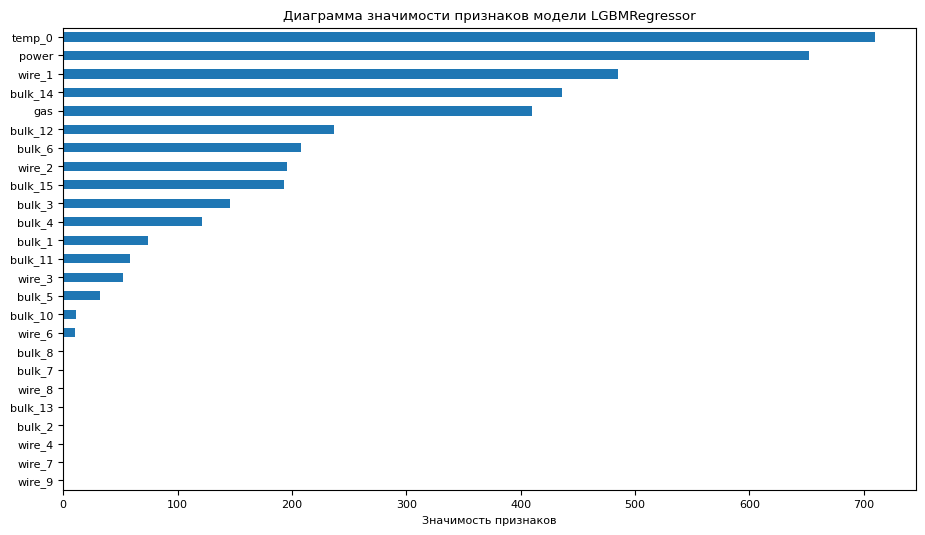

In [68]:
# серия со значениями важности признаков
importances = pd.Series(lgbm_model.feature_importances_, index=X_train.columns).sort_values()

# viz
importances.plot(kind='barh', figsize=(11, 6))
plt.title('Диаграмма значимости признаков модели LGBMRegressor')
plt.xlabel('Значимость признаков')
plt.show()

Видим, что наиболее значимые признаки – это начальная температура металла и мощность. Также в пятёрку важных для модели признаков входят проволочная добавка №1, добавка сыпучих примесей №14 и объём продуваемого инертного газа. Остальные примеси имеют более низкую значимость для нашей модели. Вообще не имеют значимости следующие признаки: проволочные добавки №№ 4, 7, 8, 9 и сыпучие примеси №№ 2, 7, 8, 13

<br><br>

## 2.8. Подведение итогов разработки модели

Итак, в ходе разработки модели машинного обучения:
- Данные были подготовлены и объединены в единый датафрейм для обучения моделей
- Проведены краткий исследовательский анализ нового датафрейма и проверка на мультиколлинеарность, определены признаки
- Данные разделены на обучающую и тестовые выборки 3:1
- Построены и испытаны несколько моделей машинного обучения, такие как линейная регрессия, дерево решений, случайный лес и LGBM
- Проведён анализ моделей, выбрана лучшая – LGBMRegressor
- Лучшая модель испытана на тестовой выборке, а также проверена на адекватность в сравнении с константной моделью
- Получена оценка значимости признаков

В результате лучшая модель LGBMRegressor показала значения MAE на кросс-валидации 6.26 и на тестовой выборке 5.69. Модель проверена на адекватность. Основными значимыми признаками для неё являются начальная температура, мощность, объем инертного газа и некоторые легирующие добавки. Таким образом, наша модель удовлетворяет заданным требованиям качества (MAE не выше 6.8) и может быть использована заказчиком для предсказания температуры стали

<br><br><br><br>

# 3. Отчет

**Название проекта:** "Предсказание температуры стали"
<br>

**Описание задачи:** Заказчик – металлургический комбинат ООО "Так закаляем сталь" – решил уменьшить потребление электроэнергии на этапе обработки стали, чтобы оптимизировать производственные расходы. Нужно построить модель, которая предскажет температуру стали
<br><br>

**В ходе уточнения задачи были получены следующие пояснения и указания:**

- Решаем задачу регрессии. Целевым признаком считаем конечную температуру металла из всех доступных замеров для партии металла. Остальные признаки определяем самостоятельно
- Для оценки качества модели используем метрику MAE – среднюю абсолютную ошибку. Критерий качества модели – MAE не более 6.8
- В работе используем данные только по тем партиям металла, для которых есть информация по всем технологическим операциям
- Из данных по температуре металла в каждой партии используем в качестве признаков только начальные и конечные значения 
- Временны́е данные для моделирования не используем
- По результатам работы также предоставляем оценку значимости признаков модели
- Для воспроизводимости результатов фиксируем сиды случайных процессов (RANDOM_STATE = 270323)
<br>


**В ходе работы над проектом:**

1. В датафреймы `arc`, `bulk`, `bulk_time`, `gas`, `temp`, `wire` и `wire_time` проведена загрузка исходных файлов со следующими данными:

    - `data_arc.csv` – данные об электродах
    - `data_bulk.csv` – данные о подаче сыпучих материалов (объём)
    - `data_bulk_time.csv` – данные о подаче сыпучих материалов (время)
    - `data_gas.csv` – данные о продувке сплава газом
    - `data_temp.csv` – результаты измерения температуры
    - `data_wire.csv` – данные о проволочных материалах (объём)
    - `data_wire_time.csv` – данные о проволочных материалах (время)
<br>

2. Проведено предварительное изучение загруженных данных, выявлены проблемные моменты, намечены задачи для предобработки данных, в ходе которой:

    - Во всех датафреймах исправлены названия столбцов
    - Типы данных приведены в соответствие (температура и сыпучие добавки – целочисленные типы данных, а мощность, объём газа и проволочные добавки – вещественные)
    - Дубликатов  не выявлено
    - Обнаружено и исправлено аномальное значение реактивной мощности в датафрейме `arc`
    - Пропущенные значения в датафреймах `bulk` и `wire` заменены на нулевые
    - Удалены пропуски в замерах температуры датафрейма `temp`
<br>


3. Проведён исследовательский анализ данных, были сделаны следующие выводы:

    - В основном все данные имеют распределения, близкие по форме к нормальному распределению, иногда с перекосами вправо, разной степени выраженности, что обусловлено физической природой большинства показателей (без отрицательных значений)
    - Для дальнейшего обучения моделей необходимо объединить разрозненные данные по всем технологическим операциям в один датафрейм
    - Поскольку в нашем случае мы не можем использовать временны́е данные в обучени моделей, необходимо в итоговом датафрейме избавиться от итераций в партиях, т.е. привести данные к такому виду, чтобы каждой партии металла соответствовала только одна запись
    - В датафреймах `arc` и `temp` преобладают партии металла с 3-6 итерациями нагрева и измерения температуры. Больше всего партий с 4 итерациями. Редко, но встречаются также партии всего с одной итерацией
    - Итерации в замерах температуры автоматически сокращаются до начального и конечного значений для каждой партии. Соответственно, в итоговую выборку войдут только партии металла с 2 и более значениями замеров температуры
    - Не смотря на то, что абсолютные временны́е данные для моделирования использовать нельзя, хорошим признаком может стать относительный временной интервал – продолжительность нагрева металла дугой
    - Таким образом, что касается итераций по нагреву, лучшим решением видится группировка по партиям металла и суммирование значений мощности и продолжительности нагрева. Таким образом мы учитываем в признаках итоговое воздействие на сплав – суммарной мощностью нагрева в течение совокупного интервала времени
    - В ходе исследования была выявлена высокая корреляция активной и реактивной мощностей, поэтому в качестве признаков необходимо или выбрать активную мощность, как непосредственное воздействие на металл, или вычислить общую мощность
    - Также было выявлено, что во всех датафреймах отсутствуют данные по некоторым партиям металла. Судя по спискам номеров, часть партий отсутствует практически во всех датафреймах
    - Так или иначе обязательным условием заказчика является использование только тех партий, для которых есть данные по всем без исключения технологическим процессам. Таким образом будем использовать inner-объединение датафреймов по номеру партии
<br>


4. В рамках подготовки данных для обучения моделей было:

    - Подготовлены и объединены данные по всем технологическим операциям в один рабочий датафрейм `df`
    - Проведён краткий исследовательский анализ нового датафрейма
    - Выполнена проверка на мультиколлинеарность признаков, часть коррелирующих и бесполезных признаков удалена: номер партии `key`, активная и реактивная мощности `a_pwr`, `r_pwr`, продолжительность нагрева сплава `time`, легирующие добавки `bulk_9`, `wire_5`
    - Определены итоговые признаки для моделирования: начальная температура металла `temp_0`, общая суммарная мощность нагрева `power` (квадратный корень из суммы квадратов активной и реактивной мощностей), объём инертного газа для продувки сплава `gas`, ряд примесей сыпучих материалов `bulk_*`, за исключением удалённой девятой и ряд проволочных добавок `wire_*`, за исключением пятой
    - Данные разделены на обучающую и тестовую выборки в соотношении 3:1
<br>


5. Были построены и обучены с подбором гиперпараметров несколько моделей машинного обучения:

    - Модель линейной регрессии `LinearRegression` показала результат MAE: 7.132. Для данной модели также были проведено обучение на масштабированных различными скейлерами данных. Это не дало результата, что вероятно связано с небольшими абсолютными значениями признаков, малым их разбросом и нормальным распределением
    - Модель дерева решений `DecisionTreeRegressor` показала результат MAE: 7.31
    - Модель случайного леса `RandomForestRegressor` показала результат MAE: 6.291
    - Модель градиентного бустинга `LGBMRegressor` показала наилучший результат MAE: 6.26. Для модели были определены следующие оптимальные гиперпараметры: скорость обучения 'learning_rate': 0.04, максимальная глубина деревьев в ансамбле 'max_depth': 12, количество эстиматоров 'n_estimators': 140, а также фиксированный сид 'random_state': 270323
<br>


6. Для лучшей модели градиентного бустинга 'LGBMRegressor':

    - Проведены испытания на тестовой выборке с результатом MAE 5.692
    - Выполнена успешная проверка на адекватность в сравнении с константной моделью. Показатели константной модели (MAE 7.49) гораздо хуже и не соответствуют даже критерию качества модели
    - Получена оценка значимости признаков. В пятёрку наиболее важных признаков ожидаемо входят начальная температура `temp_0`, суммарная мощность`power` и объём инертного газа `gas`, а также проволочная добавка `wire_1` и сыпучая `bulk_14`
<br>


**Несколько слов о планировании исследования:**

- Основные трудности в проекте заключались в ознакомлении с новой доменной областью. Требовалось хотя бы в общих чертах разобраться в технологических процессах и источниках данных для нашей задачи
- Благодаря взаимодействию с заказчиком были выяснены основные особенности технологических процессов и уточнены нюансы задачи, что позволило чётко распланировать свою исследовательскую деятельность и придерживаться плана вплоть до окончания работы и достижения результатов
- Концептуально задача была поделена на две основные части. В первой части мы провели предобработку и исследование разрозненных данных, полученных от заказчика. А во второй части отобрали и объединили только необходимые данные, обучили на них несколько моделей ML и выбрали лучшую
<br>


**В результате нашего исследования мы построили и обучили модель градиентного бустинга `LGBMRegressor`, которая уверенно удовлетворяет заданным требованиям качества (метрика MAE не выше 6.8) и может быть использована заказчиком для предсказания температуры стали**

<br><br><br><br>

# Спасибо за внимание!

In [69]:
# out
head_print(f'Общее время выполнения проекта {get_time(start_prj, time.time())}', 0)

Общее время выполнения проекта (53s)
